Training a Conv LSTM based Model for Image Segmentation

In [1]:
# !conda env create -f environment.yaml

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
# !gdown https://drive.google.com/uc?id=1I64DYabWlUU4D4ktAS8IMSrQxlaGJIKi
# !gdown https://drive.google.com/uc?id=1nhsaIqolamUPj3q34TeEBUdXg3oHZh3L

In [4]:
# Following takes a really long time.
# !unzip Dataset_Student.zip &> /dev/null

In [5]:
# # # Load image dataset
# train_dataset = datasets.ImageFolder(root='Dataset_Student/train', 
#                                      transform=transforms.ToTensor())
# unlabeled_dataset = datasets.ImageFolder(root='Dataset_Student/unlabeled',
#                                          transform=transforms.ToTensor())
# val_dataset = datasets.ImageFolder(root='Dataset_Student/val',
#                                    transform=transforms.ToTensor())

In [6]:
# # determine image mean and std
# # code from https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html

# import torch
# from torch.utils.data import DataLoader

# batch_size = 1000

# train_dev_sets = torch.utils.data.ConcatDataset([train_dataset, unlabeled_dataset])

# loader = DataLoader(
#   train_dev_sets, 
#   batch_size = batch_size, 
#   num_workers=1)

# def batch_mean_and_sd(loader):
    
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in tqdm(loader):
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (
#                       cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (
#                             cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(
#       snd_moment - fst_moment ** 2)        
#     return mean,std
  
# mean, std = batch_mean_and_sd(loader)
# print("mean and std: \n", mean, std)
# mean and std: 
#  tensor([0.5061, 0.5045, 0.5008]) tensor([0.0571, 0.0567, 0.0614])

In [7]:
# np.unique([entry[0].shape for entry in train_dataset], return_counts=True)
# all the images have the same size

In [8]:
# mask = np.load('Dataset_Student/train/video_0/mask.npy')
# print(mask.shape)
# # mask also has the same shape as the images

## Segementation Dataset

In [9]:
# Creating a custom dataset for frames
class SegmentationDataset(Dataset):
    def __init__(self, root_folder, img_transforms=None, mask_transforms=None):
        self.root_folder = root_folder
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        # Get all the folders in the root folder
        self.video_folders = os.listdir(root_folder)
        self.video_folders.sort()
        self.video_folders = [os.path.join(root_folder, folder) for folder in self.video_folders]
        self.video_folders = [folder for folder in self.video_folders if os.path.isdir(folder)]
        
    def __len__(self):
        return len(self.video_folders) * 22
    
    def __getitem__(self, idx):
        folder = self.video_folders[idx//22]
        files = os.listdir(folder)
        files = [file for file in files if file.endswith('.png')]
        # sorted on numeric index
        files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))
        
        image = plt.imread(os.path.join(folder, files[idx%22]))
        # permute the dimensions to make it (C, H, W)
        image = np.transpose(image, (2, 0, 1))
        # 22 masks for each video
        mask = np.load(os.path.join(folder, 'mask.npy'))[idx%22]
        # print(f"folder idx: {idx//22} image folder: {folder}, image file: {files[idx%22]}, mask idx: {idx%22}")
        
        if self.img_transforms:
            image = self.img_transforms(image)
        
        if self.mask_transforms:
            mask = self.mask_transforms(mask)
        
        return image, mask

img_transformations = transforms.Compose([
    torch.from_numpy,
    # transforms.Resize(40, antialias=None),
    transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
    ])
mask_transformations = transforms.Compose([torch.from_numpy])

train_dataset_segmentation_model = SegmentationDataset(root_folder='Dataset_Student/train', 
                                    img_transforms=img_transformations, 
                                    mask_transforms=mask_transformations)
val_dataset_segmentation_model = SegmentationDataset(root_folder='Dataset_Student/val', 
                                  img_transforms=img_transformations,
                                  mask_transforms=mask_transformations)

In [10]:
train_dataset_segmentation_model[0][0].shape, train_dataset_segmentation_model[0][1].shape

(torch.Size([3, 160, 240]), torch.Size([160, 240]))

In [11]:
# for i in range(23):
#     print(train_dataset[i][0].shape, train_dataset[i][1].shape)

In [12]:
len(train_dataset_segmentation_model), len(val_dataset_segmentation_model)

(22000, 22000)

In [13]:
# creating the dataloaders
train_loader = DataLoader(train_dataset_segmentation_model, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset_segmentation_model, batch_size=4, shuffle=True)
val_mask_loader = val_loader

In [14]:
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([4, 3, 160, 240])
torch.Size([4, 160, 240])


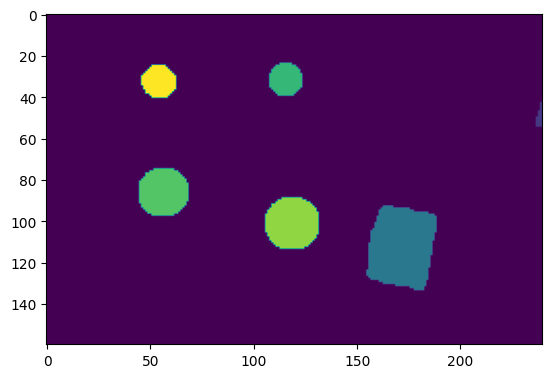

In [15]:
plt.imshow(np.load(os.path.join(train_dataset_segmentation_model.video_folders[0], 'mask.npy'))[0])
# np.unique(np.load(os.path.join(train_dataset.video_folders[0], 'mask.npy'))[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


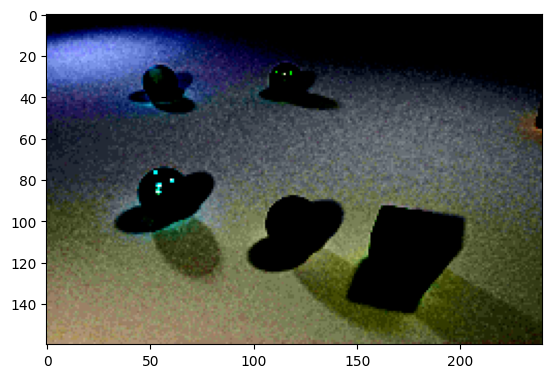

In [16]:
plt.imshow(train_dataset_segmentation_model[0][0].permute(1, 2, 0))

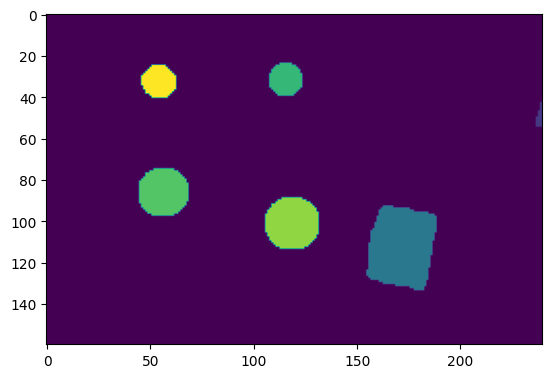

In [17]:
plt.imshow(train_dataset_segmentation_model[0][1])
# np.unique(train_dataset[0][1])

## Encoder-Decoder Architecture

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
class SegmentationModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(in_channels, 64, 1)
        
        self.convtranspose1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.fc2 = nn.Linear(64, out_channels)
        
        self.relu = nn.ReLU()
    
    def forward(self, input):
        images = self.relu(self.conv1(input))
        images = self.relu(self.conv2(images))
        images = self.relu(self.conv3(images))
        images = F.max_pool2d(images, 2)
        images = self.relu(self.convtranspose1(images))
        images = images + self.relu(self.conv4(input))
        images = images.permute(0, 2, 3, 1)
        images = self.fc2(images)
        images = images.permute(0, 3, 1, 2)
        
        return images

In [20]:
def validate_segmentation_model(model, val_loader, criterion, device):
    accuracies, losses = [], []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch
            images, masks = images.to(device), masks.long().to(device)
            outputs = model(images)
            # outputs = transforms.functional.resize(outputs.permute(0, 3, 1, 2),
            #                                        size=masks.shape[-2:], antialias=None)
            loss = criterion(outputs, masks)
            losses.append(loss.item())
            
            # calculate accuracy
            pred = torch.argmax(outputs, dim=1)
            # only the pixels that are not background are considered
            pred = pred[masks != 0]
            masks = masks[masks != 0]
            correct = (pred == masks).sum().item()
            accuracies.append(correct / masks.numel())
    return np.mean(accuracies), np.mean(losses)

In [21]:
# Train on the dataset
def train_segmentation_model(model, train_loader, epochs, criterion, optimizer, 
          val_loader=None, scheduler=None, device='cpu', early_stopper=None, save=True):
    model.train()
    best_loss = np.inf
    for epoch in range(epochs):
        losses = []
        for (images, masks) in tqdm(train_loader):
            optimizer.zero_grad()
            images, masks = images.to(device), masks.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        stmt = f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(losses):.4f}"
        if val_loader:
            val_acc, val_loss = validate_segmentation_model(model, val_loader, criterion, device)
            stmt += f" | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
            
            if val_loss < best_loss and save:
                best_loss = val_loss
                print("Saving the best model")
                torch.save(model.state_dict(), f'best_model.pth')
                
            if early_stopper and early_stopper.early_stop(loss):
                print("Early stopping")
                break
        
        if scheduler:
            scheduler.step()
            stmt += f" | LR: {scheduler.get_last_lr()[0]:.6f}"
        
        print(stmt)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [23]:
from torch.utils.data import Subset
import random

# subset of train dataset and val dataset
# train_subset_segmentation_model = Subset(train_dataset_segmentation_model, [10])
# train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)

# val_subset = Subset(val_dataset, random.sample(range(0, len(val_dataset)), 4))
# val_subset = train_subset
# val_loader = DataLoader(val_subset, batch_size=1, shuffle=True)
# val_mask_loader = DataLoader(val_subset, batch_size=1, shuffle=True)
val_subset_segmentation_model = Subset(train_dataset_segmentation_model, range(0, 40))
train_subset_segmentation_model = Subset(train_dataset_segmentation_model, range(0, 40))
train_loader_segmentation_model = DataLoader(train_subset_segmentation_model, 
                                             batch_size=1, shuffle=True)
val_loader_segmentation_model = DataLoader(val_subset_segmentation_model, 
                                           batch_size=1, shuffle=True)

# train_loader_segmentation_model = DataLoader(train_dataset_segmentation_model, 
#                                              batch_size=64, shuffle=True)
# val_loader_segmentation_model = DataLoader(val_dataset_segmentation_model, 
#                                            batch_size=64, shuffle=True)

segmodel = SegmentationModel(3, 49)
segmodel.load_state_dict(torch.load('best_model.pth', device), strict=False)
segmodel.to(device)
optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=100, min_delta=0.001)
# train_segmentation_model(segmodel, train_loader_segmentation_model, epochs=100, 
#       criterion=criterion, optimizer=optimizer, 
#       val_loader=train_loader_segmentation_model, scheduler=scheduler, 
#       device=device, early_stopper=early_stopper, save=False)

In [24]:
# Normal
# Epoch 1/10 | Train Loss: 0.0140 | Val Loss: 0.4873 | Val Acc: 0.1130 | LR: 0.009758
# Epoch 10/10 | Train Loss: 0.0293 | Val Loss: 0.3704 | Val Acc: 0.0033 | LR: 0.000100

# Skip Connection
# Epoch 1/10 | Train Loss: 0.2265 | Val Loss: 0.4270 | Val Acc: 0.0674 | LR: 0.009758
# Epoch 10/10 | Train Loss: 0.0230 | Val Loss: 1.0666 | Val Acc: 0.0073 | LR: 0.000100

In [25]:
# # load pre-trained model
# segmodel.load_state_dict(torch.load('best_model.pth', map_location=torch.device(device)))

In [26]:
# val_subset = Subset(val_dataset, random.sample(range(0, len(val_dataset)), 4))
val_subset = Subset(train_dataset_segmentation_model, [10])
val_loader = DataLoader(val_subset, batch_size=1, shuffle=True)
val_acc, val_loss = validate_segmentation_model(segmodel, val_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Val Loss: 0.0106 | Val Acc: 0.9510


In [27]:
# np.unique(outputs.detach().cpu().numpy(), return_counts=True)

In [28]:
np.unique(train_dataset_segmentation_model[10][1].numpy())

array([ 0,  5, 12, 20, 22, 25, 30], dtype=uint8)

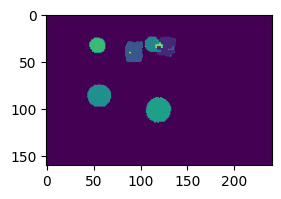

In [29]:
# Run inference on one training image

outputs = segmodel(train_dataset_segmentation_model[10][0].unsqueeze(0).to(device))
outputs = torch.argmax(outputs, dim=1).squeeze(0).detach().cpu()

axis = plt.subplot(1, 2, 1)
# axis.imshow(train_dataset[0][0].permute(1, 2, 0))
# axis.imshow(train_dataset[0][1])
axis.imshow(outputs)
# print(outputs.shape, torch.argmax(outputs, dim=1).squeeze(0).detach().cpu().shape, train_dataset[0][1].shape)
plt.show()

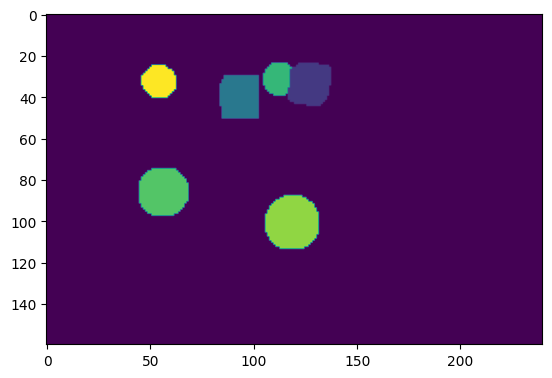

In [30]:
plt.imshow(train_dataset_segmentation_model[10][1])

## Resnet Encoder and Decoder

In [31]:
# %conda update -n base conda
# # %conda install opencv

In [32]:
from os import path
import sys
sys.path.append(path.abspath('./VPTR/'))

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training

/Users/swapnilsharma/miniforge3/envs/pred/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
encH, encW, encC = 8, 8, 528
img_channels = 1 #3 channels for BAIR datset
epochs = 50
N = 32
AE_lr = 2e-4
lam_gan = 0.01

In [34]:
from pathlib import Path

input_channels, output_channels = 3, 49
VPTR_Enc = VPTREnc(input_channels, feat_dim = encC, n_downsampling = 3).to(device)
VPTR_Dec = VPTRDec(output_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Sigmoid').to(device) #Sigmoid for MNIST, Tanh for KTH and BAIR
# VPTR_Disc = VPTRDisc(output_channels, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d).to(device)
# init_weights(VPTR_Disc)
init_weights(VPTR_Enc)
init_weights(VPTR_Dec)

optimizer = torch.optim.Adam(params = list(VPTR_Enc.parameters()) + list(VPTR_Dec.parameters()), lr=AE_lr, betas = (0.5, 0.999))
# optimizer_G = torch.optim.Adam(params = list(VPTR_Enc.parameters()) + list(VPTR_Dec.parameters()), lr=AE_lr, betas = (0.5, 0.999))
# optimizer_D = torch.optim.Adam(params = VPTR_Disc.parameters(), lr=AE_lr, betas = (0.5, 0.999))

criterion = nn.MSELoss()
loss_name_list = ['AE_MSE', 'AE_GDL', 'AE_total', 'Dtotal', 'Dfake', 'Dreal', 'AEgan']
gan_loss = GANLoss('vanilla', target_real_label=1.0, target_fake_label=0.0).to(device)
loss_dict = init_loss_dict(loss_name_list)
mse_loss = MSELoss()
gdl_loss = GDL(alpha = 1)
ckpt_save_dir = Path('/scratch/ss14412/FutureFramesDL/VPTR_ckpts/Segm_ResNetAE_MSEGDLgan_ckpt')

initialize network with normal
initialize network with normal


In [35]:
def cal_lossD(VPTR_Disc, fake_imgs, real_imgs, lam_gan):
    pred_fake = VPTR_Disc(fake_imgs.detach().flatten(0, 1))
    loss_D_fake = gan_loss(pred_fake, False)
    # Real
    pred_real = VPTR_Disc(real_imgs.flatten(0,1))
    loss_D_real = gan_loss(pred_real, True)
    # combine loss and calculate gradients
    loss_D = (loss_D_fake + loss_D_real) * 0.5 * lam_gan

    return loss_D, loss_D_fake, loss_D_real
    
def cal_lossG(VPTR_Disc, fake_imgs, real_imgs, lam_gan):
    pred_fake = VPTR_Disc(fake_imgs.flatten(0, 1))
    loss_G_gan = gan_loss(pred_fake, True)
    
    AE_MSE_loss = mse_loss(fake_imgs, real_imgs)
    AE_GDL_loss = gdl_loss(real_imgs, fake_imgs)
    #AE_L1_loss = l1_loss(fake_imgs, real_imgs)

    loss_G = lam_gan * loss_G_gan + AE_MSE_loss + AE_GDL_loss

    return loss_G, loss_G_gan, AE_MSE_loss, AE_GDL_loss

In [36]:
def single_iter(VPTR_Enc, VPTR_Dec, criterion, optimizer, sample, device, train_flag = True):
    past_frames, masks = sample
    masks = F.one_hot(masks.long(), num_classes=49).permute(0, 3, 1, 2).float()
    past_frames, masks = past_frames.unsqueeze(1), masks.unsqueeze(1)
    past_frames = past_frames.to(device)
    masks = masks.to(device)
    
    if train_flag:
        VPTR_Enc = VPTR_Enc.train()
        VPTR_Enc.zero_grad()
        VPTR_Dec = VPTR_Dec.train()
        VPTR_Dec.zero_grad()
        
        rec_frames = VPTR_Dec(VPTR_Enc(past_frames))
        # print(rec_frames.shape, masks.shape)
        # print(np.unique(rec_frames.detach().cpu().numpy(), return_counts=True))
        loss = criterion(rec_frames, masks)
        loss.backward()
        optimizer.step()
    else:
        VPTR_Enc = VPTR_Enc.eval()
        VPTR_Dec = VPTR_Dec.eval()
        with torch.no_grad():
            rec_frames = VPTR_Dec(VPTR_Enc(past_frames))
            loss = criterion(rec_frames, masks)
        
    # iter_loss_dict = {'AEgan': loss_G_gan.item(), 'AE_MSE': AE_MSE_loss.item(), 'AE_GDL': AE_GDL_loss.item(), 'AE_total': loss_G.item(), 'Dtotal': loss_D.item(), 'Dfake':loss_D_fake.item(), 'Dreal':loss_D_real.item()}
    iter_loss_dict = {'AE_total': loss.item()}
    
    return iter_loss_dict

In [37]:
train_subset_segmentation_model = Subset(train_dataset_segmentation_model, range(0, 40))
train_loader = DataLoader(train_subset_segmentation_model, 
                          batch_size=1, shuffle=True)

val_subset_segmentation_model = Subset(train_dataset_segmentation_model, range(0, 40))
val_loader = DataLoader(val_subset_segmentation_model, batch_size=1, shuffle=True)

In [38]:
# for epoch in range(1, 1000):
#         #Train
#         EpochAveMeter = AverageMeters(loss_name_list)
#         for idx, sample in enumerate(train_loader, 0):
#             iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, criterion, optimizer, sample, device, train_flag = True)
#             EpochAveMeter.iter_update(iter_loss_dict)
            
#         loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = True)
        
#         #validation
#         EpochAveMeter = AverageMeters(loss_name_list)
#         for idx, sample in enumerate(val_loader, 0):
#             iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, criterion, optimizer, sample, device, train_flag = False)
#             EpochAveMeter.iter_update(iter_loss_dict)
#         loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = False)
        
#         # save_ckpt({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec, 'VPTR_Disc': VPTR_Disc}, 
#         #         {'optimizer_G': optimizer_G, 'optimizer_D': optimizer_D}, 
#         #         epoch, loss_dict, ckpt_save_dir)
            
#         print(f'epoch {epoch}', EpochAveMeter.meters['AE_total'])

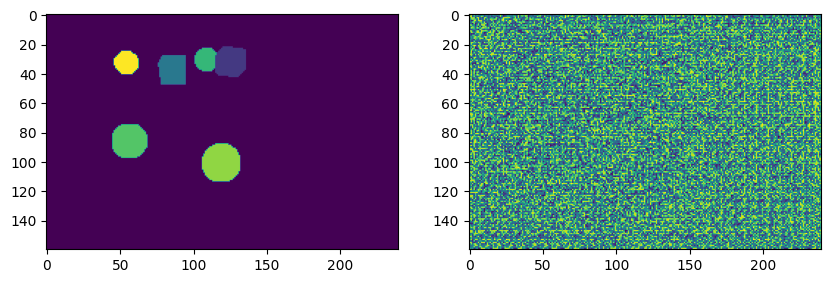

In [39]:
idx = random.choices(range(0, 40), k=1)[0]
input = train_dataset_segmentation_model[idx][0].unsqueeze(0).unsqueeze(1).to(device)
# print(input.shape)
rec_frames = VPTR_Dec(VPTR_Enc(input))

_, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(train_dataset_segmentation_model[idx][1])
axis[1].imshow(rec_frames.squeeze(0).squeeze(0).detach().argmax(dim=0).cpu())

## Seq2Seq for Mask

In [40]:
# # Creating a custom dataset for frames
# class SegmentationDataset(Dataset):
#     def __init__(self, root_folder, img_transforms=None, mask_transforms=None):
#         self.root_folder = root_folder
#         self.img_transforms = img_transforms
#         self.mask_transforms = mask_transforms
        
#         # Get all the folders in the root folder
#         self.video_folders = os.listdir(root_folder)
#         self.video_folders.sort()
#         self.video_folders = [os.path.join(root_folder, folder) for folder in self.video_folders]
#         self.video_folders = [folder for folder in self.video_folders if os.path.isdir(folder)]
        
#     def __len__(self):
#         return len(self.video_folders) * 22
    
#     def __getitem__(self, idx):
#         folder = self.video_folders[idx//22]
#         files = os.listdir(folder)
#         files = [file for file in files if file.endswith('.png')]
#         # sorted on numeric index
#         files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))
        
#         image = plt.imread(os.path.join(folder, files[idx%22]))
#         # permute the dimensions to make it (C, H, W)
#         image = np.transpose(image, (2, 0, 1))
#         # 22 masks for each video
#         mask = np.load(os.path.join(folder, 'mask.npy'))[idx%22]
#         # print(f"folder idx: {idx//22} image folder: {folder}, image file: {files[idx%22]}, mask idx: {idx%22}")
        
#         if self.img_transforms:
#             image = self.img_transforms(image)
        
#         if self.mask_transforms:
#             mask = self.mask_transforms(mask)
        
#         return image, mask

# img_transformations = transforms.Compose([
#     torch.from_numpy,
#     # transforms.Resize(40, antialias=None),
#     transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
#     ])
# mask_transformations = transforms.Compose([torch.from_numpy])

# train_dataset = SegmentationDataset(root_folder='Dataset_Student/train', 
#                                     img_transforms=img_transformations, 
#                                     mask_transforms=mask_transformations)
# val_dataset = SegmentationDataset(root_folder='Dataset_Student/val', 
#                                   img_transforms=img_transformations,
#                                   mask_transforms=mask_transformations)

## Video Frame Dataset

In [41]:
from torchvision import transforms

class VideoFrameDataset(Dataset):
    def __init__(self, root_folder, transforms=None, labeled=True, model=None):
        self.root_folder = root_folder
        self.transforms = transforms
        self.labeled = labeled
        self.model = model
        
        # Get all the folders in the root folder
        self.video_folders = os.listdir(root_folder)
        self.video_folders.sort()
        self.video_folders = [os.path.join(root_folder, folder) for folder in self.video_folders]
        print(f"Length of video folders: {len(self.video_folders)}")
        self.video_folders = [folder for folder in self.video_folders if os.path.isdir(folder)]
        print(f"Length of dir: {len(self.video_folders)}")
        
    def __len__(self):
        return len(self.video_folders)
    
    def __getitem__(self, idx):
        video_folder = self.video_folders[idx]
        if self.labeled:
            # print(video_folder, frame_idx)
            masks = np.load(os.path.join(video_folder, 'mask.npy'))
            # print(masks.shape)
            frames = masks[:11]
            label = masks[11:]
        else:
            files = [frame for frame in os.listdir(video_folder) if frame.endswith('.png')]
            files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))
            images = [plt.imread(os.path.join(video_folder, frame)) for frame in files]
            frames = np.transpose(np.array(images[:11]), (0, 3, 1, 2))
            label = np.transpose(np.array(images[11:]), (0, 3, 1, 2))
            
        if self.transforms:
            frames = self.transforms(frames)
            label = self.transforms(label)
        
        return frames, label
    
transformations = transforms.Compose([
    torch.from_numpy,
    # transforms.Resize(40, antialias=None)
])

labeled_dataset = VideoFrameDataset('Dataset_Student/train', transforms=transformations)
trick_dataset = VideoFrameDataset('Dataset_Student/train', transforms=transforms.Compose([
                                          torch.from_numpy,
                                          transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
                                          ]), 
                                      labeled=False, model=segmodel)
unlabeled_dataset = VideoFrameDataset('Dataset_Student/unlabeled', 
                                      transforms=transforms.Compose([
                                          torch.from_numpy,
                                          transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
                                          ]), 
                                      labeled=False, model=segmodel)
val_dataset = VideoFrameDataset('Dataset_Student/val', transforms=transformations)

Length of video folders: 1000
Length of dir: 1000
Length of video folders: 1000
Length of dir: 1000
Length of video folders: 13004
Length of dir: 13004
Length of video folders: 1000
Length of dir: 1000


In [42]:
print(labeled_dataset[0][0].shape, labeled_dataset[0][1].shape)
print(unlabeled_dataset[0][0].shape, unlabeled_dataset[0][1].shape)
print(val_dataset[0][0].shape, val_dataset[0][1].shape)
print(len(labeled_dataset), len(unlabeled_dataset), len(val_dataset))

torch.Size([11, 160, 240]) torch.Size([11, 160, 240])
torch.Size([11, 3, 160, 240]) torch.Size([11, 3, 160, 240])
torch.Size([11, 160, 240]) torch.Size([11, 160, 240])
1000 13004 1000


In [43]:
# (labeled_dataset[13][0][0] == labeled_dataset[11][0][2]).all()

In [44]:
# # _, axis = plt.subplots(3, 2)
# # axis[0][0].imshow(labeled_dataset[0][0][-1])
# # axis[0][1].imshow(labeled_dataset[0][1])
# # axis[2][0].imshow(labeled_dataset[0][0][1])
# # axis[2][1].imshow(labeled_dataset[1][1])
# # axis[2][0].imshow(labeled_dataset[1][0][0])
# # axis[2][1].imshow(labeled_dataset[1][1])
# _, axis = plt.subplots(4, 6)
# for j in range(2):
#     for i in range(11):
#         axis[2*j+i//6][i%6].imshow(labeled_dataset[j][0][i])
#     axis[2*j+1][5].imshow(labeled_dataset[j][1])

## VPTR implementation

#### Training the Autoencoder

In [45]:
from os import path
import sys
sys.path.append(path.abspath('./VPTR/'))

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training

In [46]:
encH, encW, encC = 8, 8, 528
img_channels = 1 #3 channels for BAIR datset
epochs = 50
N = 32
AE_lr = 2e-4
lam_gan = 0.01

In [47]:
from pathlib import Path

input_channels = 3
VPTR_Enc = VPTREnc(input_channels, feat_dim = encC, n_downsampling = 3).to(device)
VPTR_Dec = VPTRDec(input_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Sigmoid').to(device) #Sigmoid for MNIST, Tanh for KTH and BAIR
VPTR_Disc = VPTRDisc(input_channels, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d).to(device)
init_weights(VPTR_Disc)
init_weights(VPTR_Enc)
init_weights(VPTR_Dec)

optimizer = torch.optim.Adam(params = list(VPTR_Enc.parameters()) + list(VPTR_Dec.parameters()), lr=AE_lr, betas = (0.5, 0.999))
optimizer_G = torch.optim.Adam(params = list(VPTR_Enc.parameters()) + list(VPTR_Dec.parameters()), lr=AE_lr, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(params = VPTR_Disc.parameters(), lr=AE_lr, betas = (0.5, 0.999))

criterion = nn.MSELoss()
loss_name_list = ['AE_MSE', 'AE_GDL', 'AE_total', 'Dtotal', 'Dfake', 'Dreal', 'AEgan']
gan_loss = GANLoss('vanilla', target_real_label=1.0, target_fake_label=0.0).to(device)
loss_dict = init_loss_dict(loss_name_list)
mse_loss = MSELoss()
gdl_loss = GDL(alpha = 1)
ckpt_save_dir = Path('/scratch/ss14412/FutureFramesDL/VPTR_ckpts/VF_ResNetAE_MSEGDLgan_ckpt')

initialize network with normal
initialize network with normal
initialize network with normal


In [48]:
def cal_lossD(VPTR_Disc, fake_imgs, real_imgs, lam_gan):
    pred_fake = VPTR_Disc(fake_imgs.detach().flatten(0, 1))
    loss_D_fake = gan_loss(pred_fake, False)
    # Real
    pred_real = VPTR_Disc(real_imgs.flatten(0,1))
    loss_D_real = gan_loss(pred_real, True)
    # combine loss and calculate gradients
    loss_D = (loss_D_fake + loss_D_real) * 0.5 * lam_gan

    return loss_D, loss_D_fake, loss_D_real
    
def cal_lossG(VPTR_Disc, fake_imgs, real_imgs, lam_gan):
    pred_fake = VPTR_Disc(fake_imgs.flatten(0, 1))
    loss_G_gan = gan_loss(pred_fake, True)
    
    AE_MSE_loss = mse_loss(fake_imgs, real_imgs)
    AE_GDL_loss = gdl_loss(real_imgs, fake_imgs)
    #AE_L1_loss = l1_loss(fake_imgs, real_imgs)

    loss_G = lam_gan * loss_G_gan + AE_MSE_loss + AE_GDL_loss

    return loss_G, loss_G_gan, AE_MSE_loss, AE_GDL_loss

In [49]:
def single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, optimizer_G, optimizer_D, sample, device, train_flag = True):
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    x = torch.cat([past_frames, future_frames], dim = 1)
    
    if train_flag:
        VPTR_Enc = VPTR_Enc.train()
        VPTR_Enc.zero_grad()
        VPTR_Dec = VPTR_Dec.train()
        VPTR_Dec.zero_grad()

        
        rec_frames = VPTR_Dec(VPTR_Enc(x))

        #update discriminator
        VPTR_Disc = VPTR_Disc.train()
        for p in VPTR_Disc.parameters():
            p.requires_grad_(True)
        VPTR_Disc.zero_grad(set_to_none=True)

        loss_D, loss_D_fake, loss_D_real = cal_lossD(VPTR_Disc, rec_frames, x, lam_gan)
        loss_D.backward()
        optimizer_D.step()

        #update autoencoder (generator)
        for p in VPTR_Disc.parameters():
            p.requires_grad_(False)
        loss_G, loss_G_gan, AE_MSE_loss, AE_GDL_loss = cal_lossG(VPTR_Disc, rec_frames, x, lam_gan)
        loss_G.backward()
        optimizer_G.step()
    else:
        VPTR_Enc = VPTR_Enc.eval()
        VPTR_Dec = VPTR_Dec.eval()
        VPTR_Disc = VPTR_Disc.eval()
        with torch.no_grad():
            rec_frames = VPTR_Dec(VPTR_Enc(x))
            loss_D, loss_D_fake, loss_D_real = cal_lossD(VPTR_Disc, rec_frames, x, lam_gan)
            loss_G, loss_G_gan, AE_MSE_loss, AE_GDL_loss = cal_lossG(VPTR_Disc, rec_frames, x, lam_gan)
        
    iter_loss_dict = {'AEgan': loss_G_gan.item(), 'AE_MSE': AE_MSE_loss.item(), 'AE_GDL': AE_GDL_loss.item(), 'AE_total': loss_G.item(), 'Dtotal': loss_D.item(), 'Dfake':loss_D_fake.item(), 'Dreal':loss_D_real.item()}
    
    return iter_loss_dict

In [50]:
# labeled_subset = Subset(labeled_dataset, range(1))
# unlabeled_subset = Subset(unlabeled_dataset, range(1))
trick_subset = Subset(trick_dataset, range(1))
# train_subset_segmentation_model = Subset(train_dataset_segmentation_model, range(12))
# val_subset_segmentation_model = Subset(val_dataset_segmentation_model, range(12))

# labeled_loader = DataLoader(labeled_subset, batch_size=1, shuffle=True)
trick_loader = DataLoader(trick_subset, batch_size=1, shuffle=True)
# unlabeled_loader = DataLoader(unlabeled_subset, batch_size=1, shuffle=True)
# val_loader = DataLoader(labeled_subset, batch_size=1, shuffle=True)
# train_loader_segmentation_model = DataLoader(train_subset_segmentation_model, 
#                                              batch_size=12, shuffle=True)
# val_loader_segmentation_model = DataLoader(val_subset_segmentation_model, 
#                                            batch_size=12, shuffle=True)

In [51]:
from datetime import datetime

start_epoch = 0
for epoch in range(1, epochs+1):
    epoch_st = datetime.now()
    
    #Train
    EpochAveMeter = AverageMeters(loss_name_list)
    for idx, sample in tqdm(enumerate(trick_loader, 0)):
        iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, optimizer_G, 
                                     optimizer_D, sample, device, train_flag = True)
        EpochAveMeter.iter_update(iter_loss_dict)
        
    loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = True)
    
    #validation
    EpochAveMeter = AverageMeters(loss_name_list)
    for idx, sample in tqdm(enumerate(trick_loader, 0)):
        iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, optimizer_G, 
                                     optimizer_D, sample, device, train_flag = False)
        EpochAveMeter.iter_update(iter_loss_dict)
    loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = False)
    
    # save_ckpt({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec, 'VPTR_Disc': VPTR_Disc}, 
    #         {'optimizer_G': optimizer_G, 'optimizer_D': optimizer_D}, 
    #         epoch, loss_dict, ckpt_save_dir)
        
    epoch_time = datetime.now() - epoch_st
    print(f'epoch {epoch}', EpochAveMeter.meters['AE_total'])
    time_calc = epoch_time.total_seconds()/3600. * (start_epoch + epochs - epoch)
    print(f"Estimated remaining training time: {time_calc} Hours")

0it [00:00, ?it/s]/Users/swapnilsharma/miniforge3/envs/pred/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
1it [00:09,  9.08s/it]
1it [00:02,  2.50s/it]


epoch 1 AE_total 1.7465677261e+00 (1.7465677261e+00)
Estimated remaining training time: 0.1580614913888889 Hours


1it [00:08,  8.65s/it]
1it [00:02,  2.47s/it]


epoch 2 AE_total 1.7387256622e+00 (1.7387256622e+00)
Estimated remaining training time: 0.14841548000000002 Hours


1it [00:08,  8.44s/it]
1it [00:02,  2.44s/it]


epoch 3 AE_total 1.7391694784e+00 (1.7391694784e+00)
Estimated remaining training time: 0.1422144538888889 Hours


1it [00:08,  8.72s/it]
1it [00:02,  2.66s/it]


epoch 4 AE_total 1.7433482409e+00 (1.7433482409e+00)
Estimated remaining training time: 0.14553795611111112 Hours


1it [00:09,  9.06s/it]
1it [00:02,  2.41s/it]


epoch 5 AE_total 1.7480422258e+00 (1.7480422258e+00)
Estimated remaining training time: 0.1433810375 Hours


1it [00:08,  8.59s/it]
1it [00:02,  2.52s/it]


epoch 6 AE_total 1.7481718063e+00 (1.7481718063e+00)
Estimated remaining training time: 0.1358752388888889 Hours


1it [00:08,  8.63s/it]
1it [00:02,  2.47s/it]


epoch 7 AE_total 1.7462226152e+00 (1.7462226152e+00)
Estimated remaining training time: 0.13259734416666666 Hours


1it [00:09,  9.65s/it]
1it [00:05,  5.05s/it]


epoch 8 AE_total 1.7444545031e+00 (1.7444545031e+00)
Estimated remaining training time: 0.17168989833333334 Hours


1it [00:13, 13.56s/it]
1it [00:03,  3.50s/it]


epoch 9 AE_total 1.7407257557e+00 (1.7407257557e+00)
Estimated remaining training time: 0.19437939416666666 Hours


1it [02:53, 173.77s/it]
1it [00:02,  2.45s/it]


epoch 10 AE_total 1.7377419472e+00 (1.7377419472e+00)
Estimated remaining training time: 1.9581976444444442 Hours


1it [00:08,  8.38s/it]
1it [00:02,  2.43s/it]


epoch 11 AE_total 1.7332897186e+00 (1.7332897186e+00)
Estimated remaining training time: 0.1171595425 Hours


1it [00:09,  9.53s/it]
1it [00:02,  2.55s/it]


epoch 12 AE_total 1.7187401056e+00 (1.7187401056e+00)
Estimated remaining training time: 0.12762037166666668 Hours


1it [00:08,  8.27s/it]
1it [00:02,  2.35s/it]


epoch 13 AE_total 1.7007844448e+00 (1.7007844448e+00)
Estimated remaining training time: 0.10920080305555556 Hours


1it [00:12, 12.20s/it]
1it [00:02,  2.42s/it]


epoch 14 AE_total 1.6801953316e+00 (1.6801953316e+00)
Estimated remaining training time: 0.14622637 Hours


1it [00:08,  8.23s/it]
1it [00:02,  2.35s/it]


epoch 15 AE_total 1.6587477922e+00 (1.6587477922e+00)
Estimated remaining training time: 0.10287499444444445 Hours


1it [00:09,  9.20s/it]
1it [00:02,  2.74s/it]


epoch 16 AE_total 1.6379101276e+00 (1.6379101276e+00)
Estimated remaining training time: 0.11283566777777777 Hours


1it [00:08,  8.96s/it]
1it [00:02,  2.49s/it]


epoch 17 AE_total 1.6219623089e+00 (1.6219623089e+00)
Estimated remaining training time: 0.10501442416666666 Hours


1it [00:58, 58.95s/it]
1it [00:02,  2.82s/it]


epoch 18 AE_total 1.6028091908e+00 (1.6028091908e+00)
Estimated remaining training time: 0.5491624355555556 Hours


1it [00:08,  8.70s/it]
1it [00:02,  2.37s/it]


epoch 19 AE_total 1.5881756544e+00 (1.5881756544e+00)
Estimated remaining training time: 0.09537023416666666 Hours


1it [00:08,  8.21s/it]
1it [00:02,  2.51s/it]


epoch 20 AE_total 1.5747081041e+00 (1.5747081041e+00)
Estimated remaining training time: 0.08939488333333333 Hours


1it [00:08,  8.28s/it]
1it [00:02,  2.34s/it]


epoch 21 AE_total 1.5654393435e+00 (1.5654393435e+00)
Estimated remaining training time: 0.08563905416666666 Hours


1it [00:42, 42.92s/it]
1it [00:02,  2.47s/it]


epoch 22 AE_total 1.5476416349e+00 (1.5476416349e+00)
Estimated remaining training time: 0.35308628444444445 Hours


1it [00:08,  8.29s/it]
1it [00:02,  2.33s/it]


epoch 23 AE_total 1.5357617140e+00 (1.5357617140e+00)
Estimated remaining training time: 0.07969169250000001 Hours


1it [00:08,  8.13s/it]
1it [00:02,  2.50s/it]


epoch 24 AE_total 1.5230435133e+00 (1.5230435133e+00)
Estimated remaining training time: 0.07682893111111111 Hours


1it [00:08,  8.28s/it]
1it [00:02,  2.34s/it]


epoch 25 AE_total 1.5113892555e+00 (1.5113892555e+00)
Estimated remaining training time: 0.07381180555555555 Hours


1it [00:08,  8.20s/it]
1it [00:02,  2.38s/it]


epoch 26 AE_total 1.4863557816e+00 (1.4863557816e+00)
Estimated remaining training time: 0.07056398666666666 Hours


1it [03:48, 228.74s/it]
1it [00:02,  2.34s/it]


epoch 27 AE_total 1.5057928562e+00 (1.5057928562e+00)
Estimated remaining training time: 1.4764428525 Hours


1it [00:08,  8.65s/it]
1it [00:02,  2.75s/it]


epoch 28 AE_total 1.4446395636e+00 (1.4446395636e+00)
Estimated remaining training time: 0.06969244944444444 Hours


1it [00:08,  8.59s/it]
1it [00:02,  2.43s/it]


epoch 29 AE_total 1.4847790003e+00 (1.4847790003e+00)
Estimated remaining training time: 0.0642873875 Hours


1it [00:08,  8.24s/it]
1it [00:02,  2.44s/it]


epoch 30 AE_total 1.4435333014e+00 (1.4435333014e+00)
Estimated remaining training time: 0.059375116666666665 Hours


1it [04:26, 266.58s/it]
1it [00:02,  2.37s/it]


epoch 31 AE_total 1.4360954762e+00 (1.4360954762e+00)
Estimated remaining training time: 1.4194818036111112 Hours


1it [00:08,  8.26s/it]
1it [00:02,  2.48s/it]


epoch 32 AE_total 1.4195948839e+00 (1.4195948839e+00)
Estimated remaining training time: 0.05379249 Hours


1it [00:08,  8.43s/it]
1it [00:02,  2.44s/it]


epoch 33 AE_total 1.3829785585e+00 (1.3829785585e+00)
Estimated remaining training time: 0.05133840388888889 Hours


1it [00:08,  8.36s/it]
1it [00:02,  2.39s/it]


epoch 34 AE_total 1.4153285027e+00 (1.4153285027e+00)
Estimated remaining training time: 0.047826924444444446 Hours


1it [01:13, 73.63s/it]
1it [00:02,  2.57s/it]


epoch 35 AE_total 1.3897732496e+00 (1.3897732496e+00)
Estimated remaining training time: 0.31754358749999995 Hours


1it [00:08,  8.21s/it]
1it [00:02,  2.41s/it]


epoch 36 AE_total 1.3930839300e+00 (1.3930839300e+00)
Estimated remaining training time: 0.04130972222222223 Hours


1it [00:08,  8.36s/it]
1it [00:02,  2.47s/it]


epoch 37 AE_total 1.3782612085e+00 (1.3782612085e+00)
Estimated remaining training time: 0.03915407888888889 Hours


1it [00:08,  8.44s/it]
1it [00:02,  2.38s/it]


epoch 38 AE_total 1.3903131485e+00 (1.3903131485e+00)
Estimated remaining training time: 0.03610177 Hours


1it [00:09,  9.30s/it]
1it [10:55, 655.61s/it]


epoch 39 AE_total 1.3635462523e+00 (1.3635462523e+00)
Estimated remaining training time: 2.03170066 Hours


1it [00:09,  9.43s/it]
1it [00:02,  2.53s/it]


epoch 40 AE_total 1.3798571825e+00 (1.3798571825e+00)
Estimated remaining training time: 0.03322334444444444 Hours


1it [00:08,  8.18s/it]
1it [00:02,  2.36s/it]


epoch 41 AE_total 1.3637380600e+00 (1.3637380600e+00)
Estimated remaining training time: 0.026395915 Hours


1it [00:08,  8.43s/it]
1it [00:02,  2.33s/it]


epoch 42 AE_total 1.3719166517e+00 (1.3719166517e+00)
Estimated remaining training time: 0.023922746666666665 Hours


1it [00:08,  8.26s/it]
1it [00:02,  2.36s/it]


epoch 43 AE_total 1.3594975471e+00 (1.3594975471e+00)
Estimated remaining training time: 0.02066960777777778 Hours


1it [12:05, 725.16s/it]
1it [00:02,  2.40s/it]


epoch 44 AE_total 1.3628482819e+00 (1.3628482819e+00)
Estimated remaining training time: 1.212613535 Hours


1it [00:08,  8.45s/it]
1it [00:02,  2.46s/it]


epoch 45 AE_total 1.3602292538e+00 (1.3602292538e+00)
Estimated remaining training time: 0.015163993055555556 Hours


1it [00:08,  8.32s/it]
1it [00:02,  2.43s/it]


epoch 46 AE_total 1.3612632751e+00 (1.3612632751e+00)
Estimated remaining training time: 0.011958828888888889 Hours


1it [00:08,  8.29s/it]
1it [00:02,  2.36s/it]


epoch 47 AE_total 1.3581894636e+00 (1.3581894636e+00)
Estimated remaining training time: 0.0088826025 Hours


1it [16:10, 970.18s/it]
1it [11:15, 675.26s/it]


epoch 48 AE_total 1.3609480858e+00 (1.3609480858e+00)
Estimated remaining training time: 0.9141391472222221 Hours


1it [00:08,  8.71s/it]
1it [00:02,  2.34s/it]


epoch 49 AE_total 1.3581677675e+00 (1.3581677675e+00)
Estimated remaining training time: 0.003077461388888889 Hours


1it [00:08,  8.24s/it]
1it [00:02,  2.39s/it]

epoch 50 AE_total 1.3599793911e+00 (1.3599793911e+00)
Estimated remaining training time: 0.0 Hours


##### Visualize the autoencoder results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

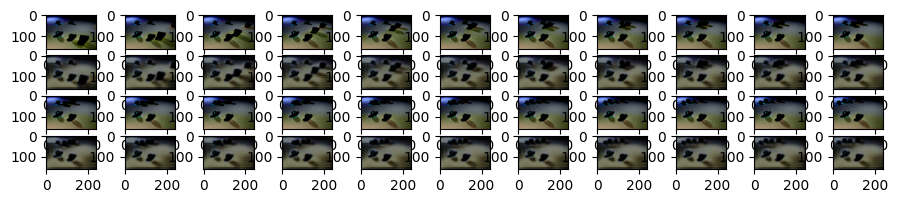

In [52]:
input = next(iter(trick_loader))[0].to(device)
masks = next(iter(trick_loader))[1].to(device)
combined = torch.cat([input, masks], dim=1)
rec_frames = VPTR_Dec(VPTR_Enc(combined))

MEAN = torch.tensor([0.5061, 0.5045, 0.5008])
STD = torch.tensor([0.0571, 0.0567, 0.0614])

_, axis = plt.subplots(4, 11, figsize=(11, 2))
for i in range(11):
    img = combined[0][i].cpu().detach()
    #  * STD[:, None, None] + MEAN[:, None, None]
    axis[0][i].imshow(img.permute(1, 2, 0).numpy())
for i in range(11):
    img = rec_frames[0][i].cpu().detach()
    #  * STD[:, None, None] + MEAN[:, None, None]
    axis[1][i].imshow(img.permute(1, 2, 0).numpy())
for i in range(11):
    img = combined[0][i+11].cpu().detach()
    #  * STD[:, None, None] + MEAN[:, None, None]
    axis[2][i].imshow(img.permute(1, 2, 0).numpy())
for i in range(11):
    img = rec_frames[0][i+11].cpu().detach()
    #  * STD[:, None, None] + MEAN[:, None, None]
    axis[3][i].imshow(img.permute(1, 2, 0).numpy())

#### Attention Module

In [53]:
def cal_lossD(VPTR_Disc, fake_imgs, real_imgs, lam_gan):
    pred_fake = VPTR_Disc(fake_imgs.detach().flatten(0, 1))
    loss_D_fake = gan_loss(pred_fake, False)
    # Real
    pred_real = VPTR_Disc(real_imgs.flatten(0,1))
    loss_D_real = gan_loss(pred_real, True)
    # combine loss and calculate gradients
    loss_D = (loss_D_fake + loss_D_real) * 0.5 * lam_gan

    return loss_D, loss_D_fake, loss_D_real
    
def cal_lossT(VPTR_Disc, fake_imgs, real_imgs, fake_feats, real_feats, lam_pc, lam_gan):
    T_MSE_loss = mse_loss(fake_imgs, real_imgs)
    T_GDL_loss = gdl_loss(real_imgs, fake_imgs)
    T_PC_loss = bpnce(F.normalize(real_feats, p=2.0, dim=2), F.normalize(fake_feats, p=2.0, dim=2))

    if VPTR_Disc is not None:
        assert lam_gan is not None, "Please input lam_gan"
        pred_fake = VPTR_Disc(fake_imgs.flatten(0, 1))
        loss_T_gan = gan_loss(pred_fake, True)
        loss_T = T_GDL_loss + T_MSE_loss + lam_pc * T_PC_loss + lam_gan * loss_T_gan
    else:
        loss_T_gan = torch.zeros(1)
        loss_T = T_GDL_loss + T_MSE_loss + lam_pc * T_PC_loss
    
    return loss_T, T_GDL_loss, T_MSE_loss, T_PC_loss, loss_T_gan

In [54]:
def single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, VPTR_Transformer, optimizer_T, optimizer_D, sample, device, train_flag = True):
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    
    with torch.no_grad():
        past_gt_feats = VPTR_Enc(past_frames)
        future_gt_feats = VPTR_Enc(future_frames)
        
    if train_flag:
        VPTR_Transformer = VPTR_Transformer.train()
        VPTR_Transformer.zero_grad(set_to_none=True)
        VPTR_Dec.zero_grad(set_to_none=True)
        
        print(past_gt_feats.shape)
        pred_future_feats = VPTR_Transformer(past_gt_feats)
        pred_frames = VPTR_Dec(pred_future_feats)
        
        if optimizer_D is not None:
            assert lam_gan is not None, "Input lam_gan"
            #update discriminator
            VPTR_Disc = VPTR_Disc.train()
            for p in VPTR_Disc.parameters():
                p.requires_grad_(True)
            VPTR_Disc.zero_grad(set_to_none=True)
            loss_D, loss_D_fake, loss_D_real = cal_lossD(VPTR_Disc, pred_frames, future_frames, lam_gan)
            loss_D.backward()
            optimizer_D.step()
        
            #update Transformer (generator)
            for p in VPTR_Disc.parameters():
                p.requires_grad_(False)

        pred_future_feats = VPTR_Transformer.NCE_projector(pred_future_feats.permute(0, 1, 3, 4, 2)).permute(0, 1, 4, 2, 3)
        future_gt_feats = VPTR_Transformer.NCE_projector(future_gt_feats.permute(0, 1, 3, 4, 2)).permute(0, 1, 4, 2, 3)
        loss_T, T_GDL_loss, T_MSE_loss, T_PC_loss, loss_T_gan = cal_lossT(VPTR_Disc, pred_frames, future_frames, pred_future_feats, future_gt_feats, lam_pc, lam_gan)
        loss_T.backward()
        nn.utils.clip_grad_norm_(VPTR_Transformer.parameters(), max_norm=max_grad_norm, norm_type=2)
        optimizer_T.step()

    else:
        if optimizer_D is not None:
            VPTR_Disc = VPTR_Disc.eval()
        VPTR_Transformer = VPTR_Transformer.eval()
        with torch.no_grad():
            pred_future_feats = VPTR_Transformer(past_gt_feats)
            pred_frames = VPTR_Dec(pred_future_feats)
            if optimizer_D is not None:
                loss_D, loss_D_fake, loss_D_real = cal_lossD(VPTR_Disc, pred_frames, future_frames, lam_gan)

            pred_future_feats = VPTR_Transformer.NCE_projector(pred_future_feats.permute(0, 1, 3, 4, 2)).permute(0, 1, 4, 2, 3)
            future_gt_feats = VPTR_Transformer.NCE_projector(future_gt_feats.permute(0, 1, 3, 4, 2)).permute(0, 1, 4, 2, 3)
            loss_T, T_GDL_loss, T_MSE_loss, T_PC_loss, loss_T_gan = cal_lossT(VPTR_Disc, pred_frames, future_frames, pred_future_feats, future_gt_feats, lam_pc, lam_gan)
    
    if optimizer_D is None:        
        loss_D, loss_D_fake, loss_D_real = torch.zeros(1), torch.zeros(1), torch.zeros(1)
    
    iter_loss_dict = {'T_total': loss_T.item(), 'T_MSE': T_MSE_loss.item(), 'T_gan': loss_T_gan.item(), 'T_GDL': T_GDL_loss.item(),  'T_bpc':T_PC_loss.item(), 'Dtotal': loss_D.item(), 'Dfake':loss_D_fake.item(), 'Dreal':loss_D_real.item()}
    
    return iter_loss_dict

In [55]:
from model import VPTRFormerNAR

ckpt_save_dir = Path('/scratch/ss14412/FutureFramesDL/VPTR_ckpts/VF_MSEGDLgan_ckpt')
num_past_frames = 11
num_future_frames = 11
encH, encW, encC = 20, 30, 528
img_channels = 3
epochs = 100
N = 16
#AE_lr = 2e-4
Transformer_lr = 1e-4
max_grad_norm = 1.0 
TSLMA_flag = False
rpe = True
padding_type = 'zero'

lam_gan = None #0.001
lam_pc = 0.1
# device = torch.device('cuda:0')

show_example_epochs = 10
save_ckpt_epochs = 2

# VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3, padding_type = padding_type).to(device)
# VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Tanh', padding_type = padding_type).to(device)
VPTR_Enc = VPTR_Enc.eval()
VPTR_Dec = VPTR_Dec.eval()

VPTR_Disc = None
#VPTR_Disc = VPTRDisc(img_channels, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d).to(device)
#VPTR_Disc = VPTR_Disc.eval()
#init_weights(VPTR_Disc)
# init_weights(VPTR_Enc)
# init_weights(VPTR_Dec)
print("Model Initialized")

VPTR_Transformer = VPTRFormerNAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                nhead=8, num_encoder_layers=4, num_decoder_layers=8, dropout=0.1, 
                                window_size=4, Spatial_FFN_hidden_ratio=4, TSLMA_flag = TSLMA_flag, rpe = rpe, 
                                device=device).to(device)
optimizer_D = None
#optimizer_D = torch.optim.Adam(params = VPTR_Disc.parameters(), lr = Transformer_lr, betas = (0.5, 0.999))
optimizer_T = torch.optim.AdamW(params = VPTR_Transformer.parameters(), lr = Transformer_lr)

Transformer_parameters = sum(p.numel() for p in VPTR_Transformer.parameters() if p.requires_grad)
print(f"NAR Transformer num_parameters: {Transformer_parameters}")

Model Initialized


/Users/swapnilsharma/miniforge3/envs/pred/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NAR Transformer num_parameters: 203021760


In [56]:
from model import GDL, MSELoss, L1Loss, GANLoss, BiPatchNCE

loss_name_list = ['T_MSE', 'T_GDL', 'T_gan', 'T_total', 'T_bpc', 'Dtotal', 'Dfake', 'Dreal']
#gan_loss = GANLoss('vanilla', target_real_label=1.0, target_fake_label=0.0).to(device)
bpnce = BiPatchNCE(N, num_future_frames, encH, encW, 1.0).to(device)
loss_dict = init_loss_dict(loss_name_list)
mse_loss = MSELoss()
gdl_loss = GDL(alpha = 1)

#load the trained autoencoder, we initialize the discriminator from scratch, for a balanced training
# loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, {}, resume_AE_ckpt, loss_name_list)
# if resume_ckpt is not None:
#     loss_dict, start_epoch = resume_training({'VPTR_Transformer': VPTR_Transformer}, 
#                                              {'optimizer_T':optimizer_T}, resume_ckpt, loss_name_list)

In [57]:
from datetime import datetime

for epoch in range(1, epochs+1):
    epoch_st = datetime.now()
    
    #Train
    EpochAveMeter = AverageMeters(loss_name_list)
    for idx, sample in enumerate(trick_loader, 0):
        iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, VPTR_Transformer, 
                                     optimizer_T, optimizer_D, sample, device, train_flag = True)
        EpochAveMeter.iter_update(iter_loss_dict)
        
    loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = True)
    # write_summary(summary_writer, loss_dict, train_flag = True)

    # if epoch % show_example_epochs == 0 or epoch == 1:
    #     NAR_show_samples(VPTR_Enc, VPTR_Dec, VPTR_Transformer, sample, ckpt_save_dir.joinpath(f'train_gifs_epoch{epoch}'))
            
    #validation
    EpochAveMeter = AverageMeters(loss_name_list)
    for idx, sample in enumerate(trick_loader, 0):
        iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, VPTR_Transformer, 
                                     optimizer_T, optimizer_D, sample, device, train_flag = False)
        EpochAveMeter.iter_update(iter_loss_dict)
    loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = False)
    # write_summary(summary_writer, loss_dict, train_flag = False)

    if epoch % save_ckpt_epochs == 0:
        save_ckpt({'VPTR_Transformer': VPTR_Transformer}, 
                {'optimizer_T': optimizer_T}, 
                epoch, loss_dict, ckpt_save_dir)
    
    # if epoch % show_example_epochs == 0 or epoch == 1:
    #     for idx, sample in enumerate(test_loader, random.randint(0, len(test_loader) - 1)):
    #         NAR_show_samples(VPTR_Enc, VPTR_Dec, VPTR_Transformer, sample, ckpt_save_dir.joinpath(f'test_gifs_epoch{epoch}'))
    #         break
        
    epoch_time = datetime.now() - epoch_st

    print(f"epoch {epoch}, {EpochAveMeter.meters['T_total']}")
    time_calc = epoch_time.total_seconds()/3600. * (start_epoch + epochs - epoch)
    print(f"Estimated remaining training time: {time_calc} Hours")

torch.Size([1, 11, 528, 20, 30])


RuntimeError: MPS backend out of memory (MPS allocated: 17.69 GB, other allocations: 423.57 MB, max allowed: 18.13 GB). Tried to allocate 53.17 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## Convolutional LSTM implementation

Code from: https://github.com/ndrplz/ConvLSTM_pytorch

### Bidirectional LSTM implementation

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        # print(f"self.hidden_dim: {self.hidden_dim}, h_next: {h_next.shape}, c_next: {c_next.shape}")

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [ ]:
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False,
                 bidirectional=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.no_of_directions = 2 if bidirectional else 1

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is None:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))
        elif len(hidden_state) != self.num_layers:
            raise NotImplementedError("Hidden state is not implemented for len(hidden_state) != self.num_layers")

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                # same convlstm cell for forward and backward
                hiddens, cells = [], []
                for i in range(self.no_of_directions):
                    _cur_layer_input = cur_layer_input if layer_idx == 0 else cur_layer_input[i]
                    index = t if i == 0 else seq_len - t - 1

                    hidden_value, cell_value = self.cell_list[layer_idx](
                        input_tensor=_cur_layer_input[:, index, :, :, :],
                        cur_state=[h[i], c[i]])
                    hiddens.append(hidden_value)
                    cells.append(cell_value)
                h, c = torch.stack(hiddens, dim=0), torch.stack(cells, dim=0)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=2)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]
        # print("layer_output_list", layer_output_list[-1].shape)
        # print("last_state_list", last_state_list[-1][0].shape)
        # print(f"self.num_layers {self.num_layers}, self.hidden_dim {self.hidden_dim}")
        # print(f"self.cell_list {self.cell_list[-1].hidden_dim}")

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            hiddens, cells = [], []
            for _ in range(self.no_of_directions):
                hidden_state, cell_state = self.cell_list[i].init_hidden(batch_size, image_size)
                hiddens.append(hidden_state)
                cells.append(cell_state)
            hiddens = torch.stack(hiddens, dim=0)
            cells = torch.stack(cells, dim=0)
            init_states.append((hiddens, cells))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, 
                 batch_first, bias, return_all_layers, segmodel=segmodel,
                 bidirectional=False):
        super(seq2seq, self).__init__()
        self.segmodel = segmodel
        self.no_of_directions = 2 if bidirectional else 1
        self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, 
                                  num_layers, batch_first, bias, return_all_layers, 
                                  bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim[-1]*self.no_of_directions, 49)
    
    def forward(self, x, masks, labeled=True):
        # x.shape: 4, 11, 49, 160, 240
        if not labeled:
            x = x.view(-1, 3, x.shape[3], x.shape[4])
            x = self.segmodel(x)
            x = x.view(-1, 11, x.shape[1], x.shape[2], x.shape[3])

            masks = masks.view(-1, 3, masks.shape[3], masks.shape[4])            
            masks = self.segmodel(masks)
            masks = masks.view(-1, 11, masks.shape[1], masks.shape[2], masks.shape[3])
            
            x, masks = x.softmax(dim=2), masks.softmax(dim=2)

        output, _ = self.conv_lstm(x) # torch.Size([direction, batch, 11, 128, 160, 240])
        output = output[-1]
        output = output.view(output.shape[1], output.shape[2], -1, output.shape[4], output.shape[5])
        opt_mask = []
        for i in range(11):
            opt = self.fc(output[:,i].permute(0, 2, 3, 1))
            opt_mask.append(opt.permute(0, 3, 1, 2))
        opt_mask = torch.stack(opt_mask, dim=1)
        return opt_mask, masks

### Plain LSTM

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


In [ ]:
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False, bidirectional=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias,
                                          bidirectional=bidirectional))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is None:
            # Since the init is done in forward. Can send image size here
            hiddens, cells = [], []
            for i in range(self.no_of_directions):
                hidden_state, cell_state = self._init_hidden(batch_size=b, image_size=(h, w))
                hiddens.append(hidden_state)
                cells.append(cell_state)
                
            hidden_state = (hiddens, cells)
        elif len(hidden_state) != self.num_layers:
            raise NotImplementedError("Hidden state is not implemented for len(hidden_state) != self.num_layers")

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, 
                 batch_first, bias, return_all_layers, segmodel=segmodel):
        super(seq2seq, self).__init__()
        self.segmodel = segmodel
        self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, 
                                  num_layers, batch_first, bias, return_all_layers)
        self.fc = nn.Linear(hidden_dim[-1], 49)
    
    def forward(self, x, masks, labeled=True):
        # x.shape: 4, 11, 49, 160, 240
        if not labeled:
            x = x.view(-1, 3, x.shape[3], x.shape[4])
            x = self.segmodel(x)
            x = x.view(-1, 11, x.shape[1], x.shape[2], x.shape[3])
            
            masks = masks.view(-1, 1, masks.shape[3], masks.shape[4])
            masks = self.segmodel(masks)
            masks = masks.view(-1, 11, masks.shape[1], masks.shape[2], masks.shape[3])
            x, masks = x.softmax(dim=2), masks.softmax(dim=1)
        # print(np.unique(masks.detach().cpu().numpy()))

        for i in range(11):
            _, output = self.conv_lstm(x[:,-11:])
            output = self.fc(output[0][0].permute(0, 2, 3, 1))
            output = output.permute(0, 3, 1, 2).unsqueeze(1)
            x = torch.concat([x, output], dim=1)
        return x[:,-11:], masks

### Training

In [ ]:
# # Load checkpoint
# checkpoint = torch.load('best_model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [ ]:
def validate_seq2seq(model, val_loader, criteria, device=device):
    model.eval()
    losses, accuracies = [], []
    with torch.no_grad():
        for (images, masks) in val_loader:
            images = F.one_hot(images.long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device)
            masks = F.one_hot(masks.long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device)
            output, masks = model(images, masks)
            output, masks = output.flatten(0, 1), masks.flatten(0, 1)
            loss = criteria(output, masks)
            # print(output.shape, masks.shape)
            pred = output.argmax(dim=1)
            masks = masks.argmax(dim=1)
            pred = pred[masks != 0]
            masks = masks[masks != 0]
            prediction = (pred == masks).sum().item()
            accuracies.append(prediction/masks.numel())
            losses.append(loss.item())
    return np.mean(losses), np.mean(accuracies)

In [ ]:
def train_seq2seq(model, val_loader, optimizer, criteria, epochs, 
          device, scheduler, labeled_loader=None, unlabeled_loader=None,
          train_loader=None, val_mask_loader=None, segm_epochs=10, 
          unlabeled_load_count=1000, early_stopper=None, save=True):
    best_loss = np.inf
    for epoch in range(epochs):
        out_string = f"Epoch {epoch+1}/{epochs}"
        
        if train_loader is not None:
            # Training for segmentation model
            model.train()
            losses = []
            for _ in range(segm_epochs):
                for (images, masks) in train_loader:
                    optimizer.zero_grad()
                    images, masks = images.to(device), masks.long().to(device)
                    outputs = model.segmodel(images)
                    loss = criterion(outputs, masks)
                    losses.append(loss.item())
                    loss.backward()
                    optimizer.step()
            out_string += f" | Segm Loss: {np.mean(losses):.4f}"
                
            if val_mask_loader:
                accuracies, losses = [], []
                model.eval()
                with torch.no_grad():
                    for (images, masks) in val_mask_loader:
                        images, masks = images.to(device), masks.long().to(device)
                        outputs = model.segmodel(images)
                        loss = criterion(outputs, masks)
                        losses.append(loss.item())
                        
                        # calculate accuracy
                        pred = torch.argmax(outputs, dim=1)
                        # only the pixels that are not background are considered
                        pred = pred[masks != 0]
                        masks = masks[masks != 0]
                        correct = (pred == masks).sum().item()
                        accuracies.append(correct / masks.numel())
                val_Acc, val_loss = np.mean(accuracies), np.mean(losses)
                out_string += f" | Segm Val Loss: {val_loss:.4f} | Segm Val Acc: {val_Acc:.4f}"
    
        if labeled_loader is not None:
            # Training for frame prediction model
            model.train()
            losses = []
            # for batch_idx, (images, masks) in enumerate(labeled_loader):
            for (images, masks) in labeled_loader:
                images = F.one_hot(images.long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device)
                masks = F.one_hot(masks.long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device)
                optimizer.zero_grad()
                output, masks = model(images, masks)
                # output and mask should be single frame
                # loss = criteria(output[:, 0], masks[:, 0])
                loss = criteria(output, masks)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            out_string += f", Labeled Loss: {np.mean(losses):.2f}"
        
        if unlabeled_loader is not None:
            model.train()
            losses = []
            for (images, masks) in unlabeled_loader:
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                output, masks = model(images, masks, False)
                # print(output.flatten(0, 1).shape, masks.flatten(0, 1).shape)
                loss = criteria(output.flatten(0, 1), masks.flatten(0, 1))
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            out_string += f", Unlabeled Loss: {np.mean(losses):.2f}"
        
        val_loss, mean_acc = validate_seq2seq(model, val_loader, criteria, device)
        if val_loss < best_loss and save:
                best_loss = val_loss
                print("Saving the best model")
                torch.save(model.state_dict(), f'complete_best_model.pth')
        out_string += f", Val Loss: {val_loss:.2f}, Mean Acc: {mean_acc:.4f}"
        out_string += f", LR: {scheduler.get_last_lr()[0]:.4f}"
                
        print(out_string)
        scheduler.step()
        
        if early_stopper is not None and early_stopper.early_stop(val_loss):
            print("Early stopping")
            break
            

In [ ]:
from torch.optim import lr_scheduler

model = seq2seq(input_dim=49,
             hidden_dim=[64, 64, 128],
             num_layers=3,
            #  hidden_dim=[64],
            #  num_layers=1,
             kernel_size=(3, 3),
             batch_first=True,
             bias=True,
             return_all_layers=False,
             bidirectional=True)

cuda_count = torch.cuda.device_count()
if cuda_count > 1:
    print("Let's use", cuda_count, "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
model.to(device)

# original saved file with DataParallel
# state_dict = torch.load('complete_best_model.pth', map_location=torch.device(device))
# # create new OrderedDict that does not contain `module.`
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)
# model.load_state_dict(torch.load('complete_best_model.pth', map_location=torch.device('cpu')))

# hyperparameters
criteria = nn.CrossEntropyLoss()
# criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
early_stopper = EarlyStopper(patience=100, min_delta=0.001)
epochs = 100

In [ ]:
import random

labeled_subset = Subset(labeled_dataset, range(1))
unlabeled_subset = Subset(unlabeled_dataset, range(1))
trick_subset = Subset(trick_dataset, range(1))
train_subset_segmentation_model = Subset(train_dataset_segmentation_model, range(12))
val_subset_segmentation_model = Subset(val_dataset_segmentation_model, range(12))

labeled_loader = DataLoader(labeled_subset, batch_size=1, shuffle=True)
trick_loader = DataLoader(trick_subset, batch_size=1, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_subset, batch_size=1, shuffle=True)
val_loader = DataLoader(labeled_subset, batch_size=1, shuffle=True)
train_loader_segmentation_model = DataLoader(train_subset_segmentation_model, 
                                             batch_size=12, shuffle=True)
val_loader_segmentation_model = DataLoader(val_subset_segmentation_model, 
                                           batch_size=12, shuffle=True)

# labeled_loader = DataLoader(labeled_dataset, batch_size=8, shuffle=True)
# unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
# train_loader_segmentation_model = DataLoader(train_dataset_segmentation_model, 
#                                              batch_size=64, shuffle=True)
# val_loader_segmentation_model = DataLoader(val_dataset_segmentation_model, 
#                                            batch_size=64, shuffle=True)
# model.segmodel.requires_grad = False
# train_seq2seq(model=model,
#       val_loader=val_loader,
#       optimizer=optimizer,
#       criteria=criteria,
#       epochs=100,
#       device=device,
#       scheduler=scheduler,
#       labeled_loader=labeled_loader,
#       unlabeled_loader=trick_loader,
#       train_loader=train_loader_segmentation_model,
#       val_mask_loader=val_loader_segmentation_model,
#       segm_epochs=10,
#       early_stopper=None,
#       save=False)

# print number of params in model
print(f"Number of parameters in model: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters in model: 1576866


In [ ]:
# x, y = next(iter(trick_loader))
# x = x.view(-1, 3, x.shape[3], x.shape[4]).to(device)
# x = model.segmodel(x)
# x = x.view(-1, 11, x.shape[1], x.shape[2], x.shape[3]).to(device)

# # y = y.view(-1, 3, y.shape[2], y.shape[3]).to(device)
# y = model.segmodel(y.to(device))
# # y = y.view(-1, y.shape[1], y.shape[2], y.shape[3]).to(device)
# print(x.shape, y.shape)

# # x = x.view(-1, 3, x.shape[3], x.shape[4])
# # x = self.segmodel(x)
# # x = x.view(-1, 11, x.shape[1], x.shape[2], x.shape[3])

# # masks = self.segmodel(masks)

In [ ]:
# print(nn.CrossEntropyLoss()(output[0], y.softmax(dim=1)))

In [ ]:
# _, axis = plt.subplots(4, 6, figsize=(20, 10))
# for i in range(11):
#     axis[i//6, i%6].imshow(x[0, i, :, :, :].softmax(dim=0).argmax(dim=0).cpu().numpy())
# # axis[1, 5].imshow(y[0, :, :, :].argmax(dim=0).cpu().numpy())
# axis[1, 5].imshow(y.softmax(dim=1)[0].softmax(dim=0).argmax(dim=0).cpu().numpy())

# labels, target = next(iter(labeled_loader))
# # print(labels.shape)
# for i in range(11):
#     # print(labels[0].shape)
#     # axis[2+ i//6, i%6].imshow(labels[0, i, :, :].cpu().numpy())
#     axis[2+ i//6, i%6].imshow(F.one_hot(labels[0, i, :, :].long(), num_classes=49).permute(2, 0, 1).argmax(dim=0).cpu().numpy())
# # axis[3, 5].imshow(target[0, :, :].cpu().numpy())
# axis[3, 5].imshow(F.one_hot(target[0, :, :].long(), num_classes=49).permute(2, 0, 1).float().argmax(dim=0).cpu().numpy())
# plt.show()

TODO:
- Print number of params

rn:
Number of parameters in model: 1576866

Hypothesis:
- Can use bidirectional lstm and then don't need to iterate over the sequence and can directly use the last hidden outputs.

---

TODOs:
- After trying to overfit on labeled dataset check if labeled loss is being correctly computed by getting the loss for zeroth data entry
- Plot the output to see what it prints

Observations:
- The labeled loss is going down very slowly.
- unlabeled and validation exactly the same after segmentation but still why the difference in loss?
   - The output is not visually correct, so def unlabeled loss is not correct.

Hypothesis:
- Model should be able to learn smth from labeled dataset as no noise.

In [ ]:
# Run inference on one training image

# input = unlabeled_dataset[10][0][0].unsqueeze(0).to(device)
input = train_dataset[0][0].unsqueeze(0).to(device)
outputs = model.segmodel(input)
outputs = torch.argmax(outputs, dim=1).squeeze(0).detach().cpu()

output2 = segmodel(input)
outputs2 = torch.argmax(output2, dim=1).squeeze(0).detach().cpu()

_, axis = plt.subplots(1, 2)
# axis.imshow(train_dataset[0][0].permute(1, 2, 0))
# axis.imshow(train_dataset[0][1])
axis[0].imshow(outputs)
axis[1].imshow(outputs2)
# print(outputs.shape, torch.argmax(outputs, dim=1).squeeze(0).detach().cpu().shape, train_dataset[0][1].shape)
plt.show()

NameError: name 'train_dataset' is not defined

In [ ]:
model.eval()

output = model(F.one_hot(labeled_subset[0][0].unsqueeze(0).long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device),
               F.one_hot(labeled_subset[0][1].unsqueeze(0).long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device))

print(trick_subset[0][0].unsqueeze(0).shape, trick_subset[0][1].unsqueeze(0).shape)
output2 = model(trick_subset[0][0].unsqueeze(0).to(device),
                trick_subset[0][1].unsqueeze(0).to(device), False)

torch.Size([1, 11, 3, 160, 240]) torch.Size([1, 11, 3, 160, 240])


In [ ]:
print(nn.CrossEntropyLoss()(output[0], output[1].float().to(device)))
print(nn.CrossEntropyLoss()(output2[0], output2[1].softmax(dim=1).float().to(device)))

tensor(0.6700, device='cuda:0', grad_fn=<DivBackward1>)
tensor(3.1961, device='cuda:0', grad_fn=<DivBackward1>)


In [ ]:
output[0][0,0].shape

torch.Size([49, 160, 240])

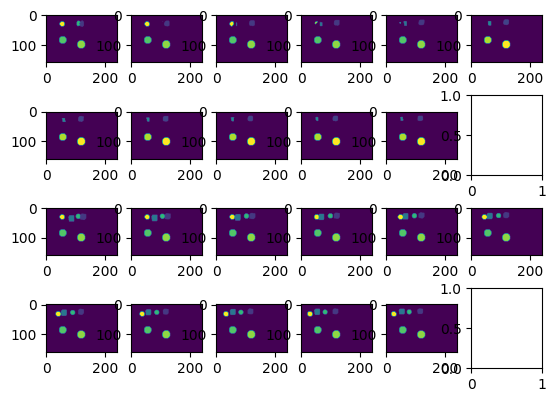

In [ ]:
_, axis = plt.subplots(4, 6)
for i in range(11):
    axis[i//6, i%6].imshow(output[0][0, i, :, :, :].argmax(dim=0).cpu().numpy())

for i in range(11):
    axis[2+ i//6, i%6].imshow(output[1][0, i, :, :, :].argmax(dim=0).cpu().numpy())

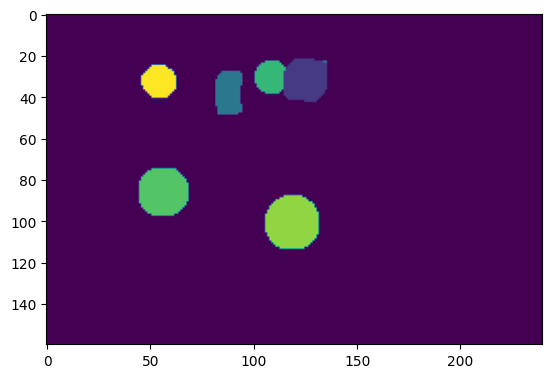

In [ ]:
plt.imshow(output2[0].argmax(1)[0].cpu())

In [ ]:
F.cross_entropy(output[0], labeled_dataset[0][1].long().unsqueeze(0).to(device)),

(tensor(0.0183, device='cuda:0', grad_fn=<NllLoss2DBackward0>),)

In [ ]:
F.cross_entropy(output[0], labeled_dataset[0][0][-1].long().unsqueeze(0).to(device))

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [ ]:
print(unlabeled_dataset[0][0].shape, unlabeled_dataset[0][1].shape)

In [ ]:
output[0].shape

torch.Size([1, 11, 49, 20, 30])

In [ ]:
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': 1187.166111328125,
#             }, 'best_model.pt')

# # load model from here --> 
# # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html